In [1]:
%matplotlib inline
# %matplotlib widget # for interactive figures

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

### Reload the line

In [3]:
line = xt.Line.from_json('pimms_00_optics.json')

Loading line from dict:   0%|          | 0/99 [00:00<?, ?it/s]

Done loading line from dict.           


### Activate extraction sextupoles

In [4]:
line['kse1'] = 1
line['kse2'] = -6.5

### Analysis from the previous notebook moved into a function:

/Users/giadarol/miniforge3/envs/xsuite-pypi/lib/python3.11/site-packages/xtrack/twiss.py:3942: RuntimeWarning: invalid value encountered in divide
  pzeta = ctx2np(particles.ptau)[mask_at_ele]/ctx2np(particles.beta0)[mask_at_ele],


{'dpx_dx_at_septum': -0.034265395726033626,
 'stable_area': 6.488485772803446e-05,
 'x_fp': array([-0.01049057, -0.00440692,  0.01401387]),
 'px_fp': array([-0.01049057, -0.00440692,  0.01401387]),
 'x_norm_fp': array([-0.00357055, -0.0014999 ,  0.00476983]),
 'px_norm_fp': array([-0.00357055, -0.0014999 ,  0.00476983])}

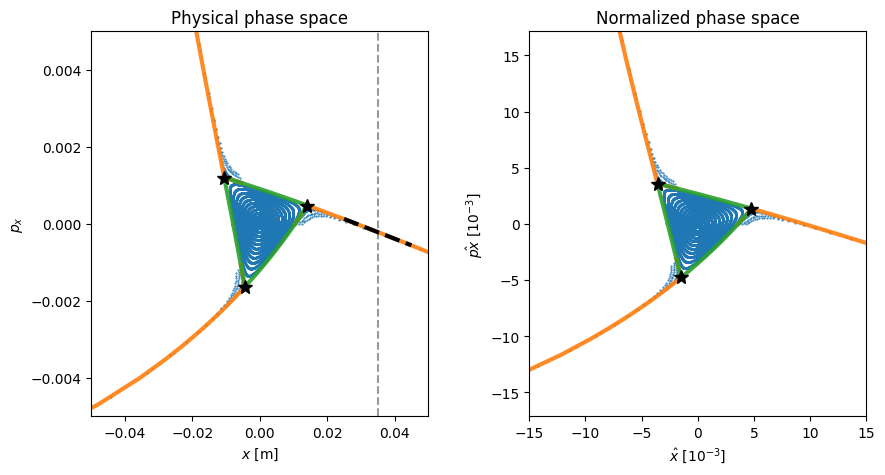

In [5]:
from phase_space_characterization import characterize_phase_space_at_septum
characterize_phase_space_at_septum(line, plot=True)

In [6]:
# Time the chracterization function (with no plot)
%time res = characterize_phase_space_at_septum(line)

CPU times: user 835 ms, sys: 1.31 s, total: 2.15 s
Wall time: 277 ms


## Resonance optimization

In [7]:
# To use the results from our function in an optimization
# we need to wrap the function in an Action class

# Define action class
class ActionSeparatrix(xt.Action):
    
    def __init__(self, line):
        self.line = line
        
    def run(self):
        out = characterize_phase_space_at_septum(self.line)
        return out
    
# Build action object
action = ActionSeparatrix(line)

In [8]:
# Test the action
action.run()

{'dpx_dx_at_septum': -0.034265395726033626,
 'stable_area': 6.488485772803446e-05,
 'x_fp': array([-0.01049057, -0.00440692,  0.01401387]),
 'px_fp': array([-0.01049057, -0.00440692,  0.01401387]),
 'x_norm_fp': array([-0.00357055, -0.0014999 ,  0.00476983]),
 'px_norm_fp': array([-0.00357055, -0.0014999 ,  0.00476983])}

In [9]:
# From the action we can create optimization targets
# (we want to control the orientation of the saparatrix
#  and the size of the stable area) 
opt = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kse1', 'kse2'], step=0.5, limits=[-7, 7]),
    targets=[
        action.target('stable_area', 1.e-4, tol=1e-5, weight=100), 
        action.target('dpx_dx_at_septum', 0.03, tol=5e-4)
    ]
)

In [10]:
# Inspect state before optimization
opt.target_status()

Target status:               alty = 6.4361e-02              
id state tag              tol_met       residue   current_val    target_val description                                 
0  ON    stable_area        False  -3.51151e-05   6.48849e-05        0.0001 'stable_area', val=0.0001, tol=1e-05, we ...
1  ON    dpx_dx_at_septum   False    -0.0642654    -0.0342654          0.03 'dpx_dx_at_septum', val=0.03, tol=0.0005 ...


### How to use an external python optimizer

We could get the solution simply calling `opt.solve()` which uses the Xsuite internal optimizer.

For some problems you might want to use a different optimizer (e.g. a derivative-free one) because it is more suited to your problem. For example here we show how to apply the [Py-BOBYQA optimizer](https://numericalalgorithmsgroup.github.io/pybobyqa/build/html/index.html) to our non-linear match problem.

In [11]:
# We extract a the merit function from our Xsuite optimizer objects
merit_function = opt.get_merit_function(
        return_scalar=True, # Py-BOBYQA wants a scalar merit function
        check_limits=False) # Py-BOBYQA wants to explore a bit outside the enforced limits

In [12]:
# Extract limits and starting point from merit function
bounds = merit_function.get_x_limits()
x0 = merit_function.get_x()

In [13]:
# Search optimum using Py-BOBYQA
import pybobyqa
soln = pybobyqa.solve(merit_function, x0=x0,
            bounds=bounds.T, # wants them transposed...
            rhobeg=5, rhoend=1e-4, maxfun=30,
            objfun_has_noise=True, # <-- helps in this case
            seek_global_minimum=True)
soln.x

ModuleNotFoundError: No module named 'pybobyqa'

In [ ]:
# Set found solution in the line
merit_function.set_x(soln.x)

In [ ]:
# Status after optimization
opt.target_status()
opt.vary_status()

In [ ]:
# Log solution in Xsuite optimizer log
opt.tag('bobyqa solution')
# Inspect the log
opt.log()

In [ ]:
# Visualize phase space after optimization
characterize_phase_space_at_septum(line, plot=True)

## Reload points from the optimization log

In [ ]:
opt.log()

In [ ]:
# Reload initial point
opt.reload(0)

In [ ]:
opt.vary_status()

In [ ]:
characterize_phase_space_at_septum(line, plot=True)

In [ ]:
# Reload tagged point
opt.reload(tag='bobyqa solution')

In [ ]:
characterize_phase_space_at_septum(line, plot=True)

### Save line with tuned extraction

In [ ]:
line.to_json('pimms_02_tuned.json')